In [1]:
import json
import numpy
import pickle
import random

import pandas as pd
 
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

from CGRtools import smiles

import warnings
warnings.filterwarnings("ignore")

### Introduction

#### The Passerini reaction is a classic multicomponent organic reaction that combines three different components to form an α-acyloxy amide (an ester-amide compound).

**What is it?**

It is a three-component reaction involving:

    - A carboxylic acid  
    - An aldehyde (or ketone)  
    - An isocyanide

These three react to form an α-acyloxy amide in a single step.

#### Carboxylic acid + Aldehyde (or ketone) + Isocyanide  →  α-acyloxy amide

### 1. Load AFIR reactions

In [2]:
with open('passerini_reaction_steps.json', 'r') as f:
    data = json.load(f)
print(f"Total number of reactions: {len(data)}")

Total number of reactions: 2416


### 2. Read, map and standardize reactions

In [3]:
from synplan.chem.data.standardizing import (
    ReactionMappingStandardizer,
    FunctionalGroupsStandardizer,
    KekuleFormStandardizer,
    CheckValenceStandardizer,
    ImplicifyHydrogensStandardizer,
    CheckIsotopesStandardizer,
    AromaticFormStandardizer,
    MappingFixStandardizer,
    UnchangedPartsStandardizer,
    DuplicateReactionStandardizer,
)

In [4]:
stand_list = [
    FunctionalGroupsStandardizer(),
    KekuleFormStandardizer(),
    CheckValenceStandardizer(),
    ImplicifyHydrogensStandardizer(),
    CheckIsotopesStandardizer(),
    AromaticFormStandardizer(),
    MappingFixStandardizer(),
    UnchangedPartsStandardizer(),
]

In [5]:
reactions_orig = []
reactions_mapped = []
reactions_stand = []

mapping_stand = ReactionMappingStandardizer()
for d in tqdm(data[:]):
    
    smi = f"{d['smiles_reactants']}>>{d['smiles_products']}"
    
    # 1. Read original reaction
    r_orig = smiles(smi)
    r_orig.canonicalize()
    r_orig.clean2d()
    
    # 2. Map original reactions
    try:
        r_mapped = mapping_stand(r_orig)
        r_mapped.clean2d()
    except Exception as e:
        # print(e)
        continue

    # 3. Standardize mapped reactions
    passed = True
    r_stand = r_mapped
    for stand in stand_list:
        try:
            r_stand = stand(r_stand)
        except Exception as e:
            # print(e)
            passed = False
    
    # 4. Add final reactions
    if passed:
        r_stand.clean2d()
        #
        reactions_orig.append(r_orig)
        reactions_mapped.append(r_mapped)
        reactions_stand.append(r_stand)

100%|███████████████████████████████████████████████████████████████████████████████| 2416/2416 [07:03<00:00,  5.70it/s]


In [6]:
print(
    f"Initial amount of reactions {len(data)}\n"
    f"Read amount of reactions {len(reactions_orig)}\n"
    f"Mapped amount of reactions {len(reactions_mapped)}\n"
    f"Standardized amount of reactions {len(reactions_stand)}"
)

Initial amount of reactions 2416
Read amount of reactions 2110
Mapped amount of reactions 2110
Standardized amount of reactions 2110


### 3. Calculate reaction statistics

In [7]:
from collections import Counter

In [8]:
react_num, prod_num = [], []
for r in reactions_stand:
    if r:
        react_num.append(len(r.reactants))
        prod_num.append(len(r.products))

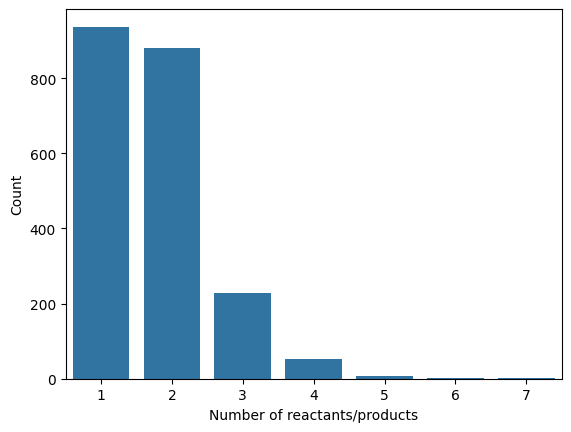

In [9]:
counts = Counter(react_num)
# counts = Counter(prod_num)

df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df.columns = ['value', 'count']
# Plot
sns.barplot(x='value', y='count', data=df)
plt.xlabel('Number of reactants/products')
plt.ylabel('Count')
plt.show()

### 4. Extract reaction rules

In [10]:
import pickle
from collections import Counter
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from synplan.utils.config import RuleExtractionConfig
from synplan.chem.reaction_rules.extraction import extract_rules_from_reactions

In [12]:
extraction_config = RuleExtractionConfig(
    
    min_popularity=1,
    environment_atom_count=1,
    
    single_reactant_only=False,
    multicenter_rules=True,
    include_rings=False,
    keep_leaving_groups=True,
    keep_incoming_groups=False,
    keep_reagents=False,
    include_func_groups=False,
    func_groups_list=[],
    atom_info_retention={
        "reaction_center": {
            "neighbors": True,  
            "hybridization": True,  
            "implicit_hydrogens": False,  
            "ring_sizes": False,  
        },
        "environment": {
            "neighbors": False,  
            "hybridization": False,  
            "implicit_hydrogens": False,  
            "ring_sizes": False,
        },
    },
)

In [13]:
reaction_data_path = "passerini_reactions_stand.smi"
reaction_rules_path = "passerini_reaction_rules.pickle"

# convert reactions into SynPlanner input format
pd.DataFrame([format(i, "m") for i in reactions_stand]).to_csv(reaction_data_path, header=None, index=False)

In [14]:
extract_rules_from_reactions(
    config=extraction_config,  # the configuration settings for rule extraction
    reaction_data_path=reaction_data_path,  # path to the reaction data file
    reaction_rules_path=reaction_rules_path,  # path to the pickle file where the extracted reaction rules will be stored
    num_cpus=4,
    batch_size=100,
)

Number of reactions processed: 364 [00:00](pid=3550967) /storage/dmitry/miniforge3/envs/synplan/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Number of reactions processed: 2110 [00:11]
(pid=3550968) /storage/dmitry/miniforge3/envs/synplan/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication f

Number of extracted reaction rules: 1718


In [15]:
# read extracted reaction rules
with open(reaction_rules_path, "rb") as f:
    reaction_rules_tuple = pickle.load(f)
    reaction_rules_list = [i[0] for i in reaction_rules_tuple]
for rule in reaction_rules_list:
    rule.clean2d()

In [16]:
rule_counts = [len(i[1]) for i in reaction_rules_tuple]
Counter(rule_counts)

Counter({1: 1560, 2: 115, 3: 32, 5: 6, 4: 4, 7: 1})

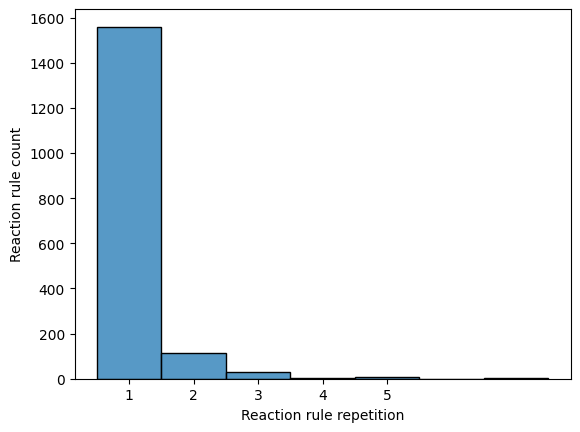

In [17]:
bins = [1, 2, 3, 4, 5]

sns.histplot(rule_counts, bins=bins, discrete=True)
plt.xlabel('Reaction rule repetition')
plt.ylabel('Reaction rule count')
plt.xticks(bins)  # Set exact x-axis ticks
plt.show()

In [18]:
reaction_rules_list[0]

In [19]:
reaction_rules_list[1]

In [20]:
reaction_rules_list[2]

In [21]:
reaction_rules_list[3]

In [22]:
reaction_rules_list[4]

### 5. Reaction rule application rate

In [23]:
from synplan.utils.loading import load_reaction_rules, load_building_blocks

from synplan.chem.precursor import Precursor
from synplan.chem.reaction import Reaction, apply_reaction_rule

from collections import Counter, defaultdict

In [24]:
with open("passerini_reactions_stand.smi", "r") as f:
    reacts = f.readlines()
reacts = [smiles(i) for i in reacts]
# Take random precursors
cand_list = []
for r in reacts:
    cand_list.extend(r.reactants)
    cand_list.extend(r.products)

In [25]:
rrs_list = load_reaction_rules(reaction_rules_path)

n_dict = defaultdict(int)
for mol in tqdm(cand_list[:]):
    precursor = Precursor(mol)
    for r_id, rule in enumerate(rrs_list):
        products  = list(apply_reaction_rule(precursor.molecule, rule))
        if products:
            n_dict[r_id] += 1

100%|███████████████████████████████████████████████████████████████████████████████| 7305/7305 [07:21<00:00, 16.55it/s]


In [26]:
res_df = pd.DataFrame({"RULE_ID":n_dict.keys(), "RULE_APP":n_dict.values()})
res_df.sort_values(by="RULE_APP", ascending=False).head(20)

,RULE_ID,RULE_APP
10,370,3521
15,1042,3521
11,378,3521
19,1086,3521
18,1069,3521
20,1088,3521
5,1005,2800
34,97,2085
97,698,2081
98,875,1776


In [35]:
reaction_rules_list[97]

In [36]:
reaction_rules_tuple[97]

(<CGRtools.containers.reaction.ReactionContainer at 0x7f1d866f21a0>,
 [251, 543])

In [37]:
reactions_stand[251]

In [38]:
reactions_orig[251]